+---------+-------------+
| Late    |   phi(Late) |
+=========+=============+
| Late(0) |      0.7200 |
+---------+-------------+
| Late(1) |      0.2800 |
+---------+-------------+


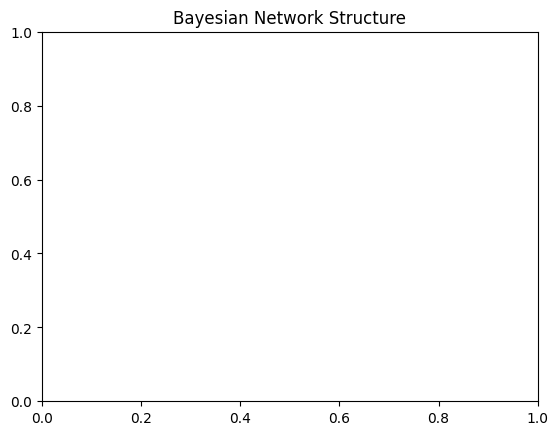

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Define the Structure of the Bayesian Network
model = BayesianModel([('Weather', 'Traffic'), ('Traffic', 'Late')])

# Step 2: Define Conditional Probability Tables (CPTs)
# Weather CPD
cpd_weather = TabularCPD(variable='Weather', variable_card=2, values=[[0.7], [0.3]])  # 70% Sunny, 30% Rainy

# Traffic CPD given Weather
cpd_traffic = TabularCPD(variable='Traffic', variable_card=2,
                         values=[[0.8, 0.4],  # Light traffic given Sunny, Rainy
                                 [0.2, 0.6]],
                         evidence=['Weather'],
                         evidence_card=[2])

# Late CPD given Traffic
cpd_late = TabularCPD(variable='Late', variable_card=2,
                      values=[[0.9, 0.6],  # On Time given Light, Heavy traffic
                              [0.1, 0.4]],
                      evidence=['Traffic'],
                      evidence_card=[2])

# Adding CPDs to the model
model.add_cpds(cpd_weather, cpd_traffic, cpd_late)

# Step 3: Verify the model
assert model.check_model()

# Step 4: Perform Exact Inference
inference = VariableElimination(model)
prob_late_given_rainy = inference.query(variables=['Late'], evidence={'Weather': 1})  # Weather = Rainy is represented by 1

print(prob_late_given_rainy)

# Step 5: Simulate a Dataset for Parameter Learning
data = pd.DataFrame(data={
    'Weather': np.random.choice(['Sunny', 'Rainy'], size=1000, p=[0.7, 0.3]),
    'Traffic': np.random.choice(['Light', 'Heavy'], size=1000),
    'Late': np.random.choice(['On Time', 'Late'], size=1000)
})

# Adjusting Traffic based on Weather for simulation purposes
data.loc[data['Weather'] == 'Sunny', 'Traffic'] = np.random.choice(['Light', 'Heavy'], size=data[data['Weather'] == 'Sunny'].shape[0], p=[0.8, 0.2])
data.loc[data['Weather'] == 'Rainy', 'Traffic'] = np.random.choice(['Light', 'Heavy'], size=data[data['Weather'] == 'Rainy'].shape[0], p=[0.4, 0.6])

# Adjusting Late based on Traffic for simulation purposes
data.loc[data['Traffic'] == 'Light', 'Late'] = np.random.choice(['On Time', 'Late'], size=data[data['Traffic'] == 'Light'].shape[0], p=[0.9, 0.1])
data.loc[data['Traffic'] == 'Heavy', 'Late'] = np.random.choice(['On Time', 'Late'], size=data[data['Traffic'] == 'Heavy'].shape[0], p=[0.6, 0.4])

# Step 6: Estimate Parameters using Maximum Likelihood Estimation
from pgmpy.estimators import MaximumLikelihoodEstimator

model.fit(data, estimator=MaximumLikelihoodEstimator)

# Step 7: Visualize the Network Structure
pos = nx.spring_layout(model)
plt.title("Bayesian Network Structure")
plt.show()